You may remember from last semester that the first step is always to initialize things in the python notebook.

In [1]:
import numpy as np
import matplotlib
import scipy as sp
from scipy.integrate import odeint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Conveniently, astropy has all the latest cosmological parameters available as a module. Here we import them to simulate our universe.

In [ ]:
# Import cosmological constants from latest Planck resutls via astropy
import astropy.units as u
from astropy.constants import G, h, k_B

from astropy.cosmology import Planck15
omega_m = Planck15.Odm0+Planck15.Ob0 # total matter = dark matter + baryons
omega_de = Planck15.Ode0
omega_r = Planck15.Ogamma0
H0 = Planck15.H0 /u.km*u.Mpc*u.s*3.154e+7 #need to divide out the units to make H0 dimensionless, and change from s to yr.

In [2]:
# Import cosmological constants from latest Planck resutls via astropy
import astropy.units as u
from astropy.constants import G, h, k_B

from astropy.cosmology import Planck15
omega_m = Planck15.Odm0+Planck15.Ob0 # total matter = dark matter + baryons
omega_de = Planck15.Ode0
omega_r = Planck15.Ogamma0
H0 = Planck15.H0 /u.km*u.Mpc*u.s*3.154e+7 #need to divide out the units to make H0 dimensionless, and change from s to yr.

The complete Friedmann equation for our universe includes three types of "stuff" each with their own equation of state, plus a term that can account for space-time curvature (Ryden, equation 6.6):

${\frac {H^{2}}{H_0^{2}}}= \frac{\Omega _{r,0}}{a^{4}} + \frac{\Omega _{m,0}}{a^{3}} + \Omega _{\Lambda,0} + \frac{1 - \Omega_{0}}{a^{2}}.$

Observations indicate our universe is very close to flat, but may not be exactly flat, so that last term may NOT be zero.

We would like to plot the scale factor as a function of time. Since $H(t) = \frac{\dot a^2}{a^2}$ we can re-arrange the Friedmann equation to be in terms of $a$ and $t$ and integrate it numerically:

${\dot a^{2}}= H_{0}^{2} \big( \frac{\Omega _{r,0}}{a^{2}} + \frac{\Omega _{m,0}}{a} + \Omega _{\Lambda,0}a^2 + 1 - \Omega_{0}. \big)$


In [3]:
def Friedmann(a, t):
    # The above declaration of the function has three optional arguments
    #   so that you can pass any values for the dimensionless density of
    #   radiation, matter of dark energy
    global omega_r, omega_m, omega_de
    dadt = H0*np.sqrt( omega_r*a**-2 + omega_m*a**-1 + omega_de*a*2 + (1-omega_r-omega_m-omega_de) )
    return dadt

We now need to choose some reasonable limits for integration in time... something very small but not zero!

In [7]:
timeStep = 1.0e7					# in years
rho_crit = 9.3e-27
omega_r = 0
omega_m = 0.3
omega_de = 2.8

print "Omega_r = ",omega_r
print "Omega_m = ",omega_m
print "Omega_de = ",omega_de

Omega_r =  0
Omega_m =  0.3
Omega_de =  2.8


In [8]:
# note: couldn't get integrator to work, so brute force evaluated the Friedmann equation forward and backward in time.
import math

# Constants
hubbleConst = 7.2e-11        # in inverse years
gravConst = 66450            # in m^3 / kg / yr^2
matterDensity = omega_m*rho_crit
radiationDensity = omega_r*rho_crit
darkEnergyDensity = omega_de*rho_crit

darkEnergyW = -1.0					# dimensionless equation-of-state parameter
darkEnergyFactor = 3.0 * darkEnergyW + 1.0
darkEnergyPower = 3.0 * darkEnergyW + 2.0


# Run simulation backward from present day until scale factor is < 0.01

lResultsBackward = []

curTime = 0.0
curScale = 1.0
curHubble = hubbleConst

while curScale > 0.01:
    matterTerm = matterDensity / (curScale ** 2)
    radiationTerm = 2.0 * radiationDensity / (curScale ** 3)
    darkEnergyTerm = darkEnergyFactor * darkEnergyDensity / (curScale ** darkEnergyPower)

    accel = -4.0/3.0 * math.pi * gravConst * (matterTerm + radiationTerm + darkEnergyTerm)
    curHubble = curHubble - timeStep * accel
    curScale = curScale - timeStep * curHubble
    curTime = curTime - timeStep
    lResultsBackward.append((curTime / 1.0e9, curScale))
    if len(lResultsBackward) > 1e4:
        break

# Run simulation forward from present day for another 10 billion years

lResultsForward = []

curTime = 0.0
curScale = 1.0
curHubble = hubbleConst

while curTime < 1.0e10:
	matterTerm = matterDensity / (curScale ** 2)
	radiationTerm = 2.0 * radiationDensity / (curScale ** 3)
	darkEnergyTerm = darkEnergyFactor * darkEnergyDensity / (curScale ** darkEnergyPower)
	
	accel = -4.0/3.0 * math.pi * gravConst * (matterTerm + radiationTerm + darkEnergyTerm)
	curHubble = curHubble + timeStep * accel
	curScale = curScale + timeStep * curHubble
	curTime = curTime + timeStep

	lResultsForward.append((curTime / 1.0e9, curScale))

# put together forward and backward integration
lResultsBackward.reverse()
lResults = lResultsBackward + [(0.0, 1.0)] + lResultsForward

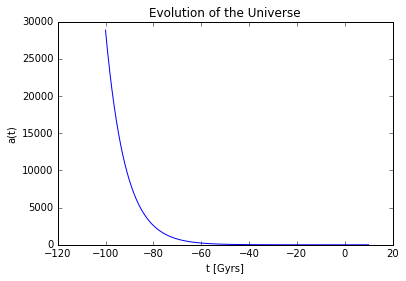

In [9]:
plt.figure()
plt.title("Evolution of the Universe")
plt.xlabel("t [Gyrs]")
plt.ylabel("a(t)")

#comparing to analytic solution
#a = odeint(Friedmann, a_0, t)
#a = np.array(a).flatten()
#plt.plot(t[1:],a[1:]) 

t = []
a = []
for i in range(len(lResults)):
    t.append(lResults[i][0])
    a.append(lResults[i][1])

plt.plot(t,a)

For today's class, see if you can find a combination of values for $\Omega_m$, $\Omega_r$ and $\Omega_\Lambda$ to create a collapsing universe, a "big bounce" universe that doesn't originate with a big bang, or a "loitering universe" where a(t) = 1 over several billion years.